In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [3]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *

In [4]:
from detect_intermediates import *
from interpret_tICs import *

In [9]:
from mor_h8_feature_types import *
from get_variable_names import *
from mor_ligand_atom_residue_tica_config import *
from residue import Residue, Atom
ori_feature_name = copy.deepcopy(feature_name)

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib as mpl
from seaborn.apionly import set_palette
from IPython.display import set_matplotlib_formats

# configure plotting
set_matplotlib_formats('pdf', 'svg')
set_palette('Set1', n_colors=15, desat=None)

In [7]:
rho = 0.0025
rho_string = "0pt0025"

In [10]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA" %ori_feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)



/home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA
/home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA


In [11]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

273


<AsyncMapResult: chdir>

In [12]:
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = True, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=dview, schemes=schemes)

structure
/home/enf/md_simulations/MOR/4dkl_R_for_conformation.pdb
structure
None
mdraj_index_combinations[0:10]
[(133, 4), (133, 146), (133, 62), (133, 128), (133, 261), (133, 274), (133, 67), (133, 29), (133, 27), (133, 69)]
contact_features[0:10]
[[ILE198, ILE69], [ILE198, ARG211], [ILE198, ASN127], [ILE198, ILE193], [ILE198, ASN332], [ILE198, ARG345], [ILE198, THR132], [ILE198, VAL94], [ILE198, VAL92], [ILE198, PRO134]]
About to compute 36315 features
(1, 36315)
cutoff
0.66
distances[0:10]
[[ 2.9838984   2.29805589  1.95851779 ...,  3.44139647  2.53797245
   3.89411235]]
There are 1963 residue-residue contacts below cutoff in structure.
structure
/home/enf/md_simulations/MOR/5c1m.pdb
structure
None
mdraj_index_combinations[0:10]
[(146, 17), (146, 159), (146, 75), (146, 141), (146, 280), (146, 293), (146, 80), (146, 42), (146, 40), (146, 82)]
contact_features[0:10]
[[ILE198, ILE69], [ILE198, ARG211], [ILE198, ASN127], [ILE198, ILE193], [ILE198, ASN332], [ILE198, ARG345], [ILE198, TH

In [21]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)
print(feature_residues[0])
print(feature_residues[0][0].__dict__)
print(feature_residues[0][1].__dict__)
print(feature_residues[727])

(Lig900-N1, Ile198)
{'mdtraj_rep': 'Lig900-N1', 'chain_id': 'L', 'res_name': 'LIG', 'resSeq': 900, 'atom_id': None, 'atom_name': 'N1'}
{'ballosteros_weinstein': None, 'chain_name': None, 'CA': False, 'chain_id': 'R', 'res_name': 'Ile198', 'resSeq': 198, 'mean': None}
(Lig900-C17, Val316)


In [73]:
[i for i in range(0, len(feature_residues)) if ("N1" in str(feature_residues[i]) and "147" in str(feature_residues[i])) or ("O1" in str(feature_residues[i]) and "297" in str(feature_residues[i])) or ("N1" in str(feature_residues[i]) and "326" in str(feature_residues[i]))]

[143, 175, 190]

In [61]:
feature_residues[175]

(Lig900-N1, Asp147)

In [ ]:
feature_files = get_trajectory_files(features_dir, ".dataset")
specific_features = [load_file(filename)[:,[143, 175, 190]] for filename in feature_files]

loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-1.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_0-3.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-1.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4dkl_5c1m_under_cutoff6A/Rep_1-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/featuresall_residues_4

In [ ]:
good_trajs = []
for i, traj in enumerate(specific_features):
    if len(np.where((traj[:,0] < 0.4) & (traj[:,1] < 0.7))[0]) > 0: good_trajs.append(i)
[get_trajectory_files(traj_dir, traj_ext)[i] for i in good_trajs]

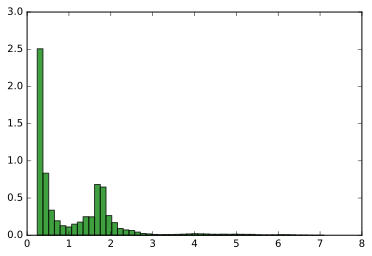

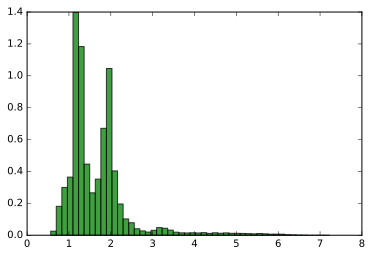

In [60]:
plt.clf()
plt.hist(np.concatenate(specific_features)[:,0], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()
plt.hist(np.concatenate(specific_features)[:,1], 50, normed=1, facecolor='green', alpha=0.75)
plt.show()


In [13]:
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext)

loading feature files
(313, 4440)
[ 0.52254224  0.30574301  0.1396205   0.4909384   0.13317047  0.34940535
  0.33360404  0.45975044  0.83246815  0.65423036]
(156,)
[  1.08597369e-03   1.51058019e-03   7.97656230e-06 ...,   9.22748528e-04
   1.23964557e-02   1.51988519e-02]loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/Rep_BFNA_CO_0-0.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/Rep_COB_2-4.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/Rep_BFNA_CO_2-2.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/Rep_CO_1-3.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/Rep_COB_3-4.dataset
loading /home/enf/md_simulations/MOR/ligand_binding/h5_new/featuresall_residues_

In [13]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [ ]:
%load_ext autoreload
%autoreload 2

In [12]:
from interpret_tICs import *
tic_components_dir = tica_dir
interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_tica_coords.h5"...
Interpreting tIC 1
feature_importances_df.shape
(10, 7)
residue_importances_df.shape
(14, 3)
        feature_name       res_i   res_j  resid_i  resid_j  importance  \
4   Lig900-N1-Asp147   Lig900-N1  Asp147      900      147    0.461965   
5   Lig900-C7-Val300   Lig900-C7  Val300      900      300    0.422095   
1   Lig900-N1-Tyr299   Lig900-N1  Tyr299      900      299   -0.383959   
3   Lig900-N1-Thr218   Lig900-N1  Thr218      900      218   -0.312445   
6  Lig900-C17-Ile296  Lig900-C17  Ile296      900      296    0.218596   
8  Lig900-C26-Cys217  Lig900-C26  Cys217      900      217    0.178930   
9  Lig900-C26-Thr218  Lig900-C26  Thr218      900      218    0.177101   
7   Lig900-O2-Thr312   Lig900-O2  Thr312      900      312   -0.158275   
0   Lig900-N1-Arg211   Lig900-

[(Lig900-N1, Tyr149),
 (Lig900-O1, Ser145),
 (Lig900-N1, Asn230),
 (Lig900-C26, Pro134),
 (Lig900-O1, Asn150),
 (Lig900-C26, Met205),
 (Lig900-C17, Ile322),
 (Lig900-C17, Cys159),
 (Lig900-C17, Trp133),
 (Lig900-N1, Phe320),
 (Lig900-N1, Ile306),
 (Lig900-N1, Cys217),
 (Lig900-C26, Ser222),
 (Lig900-N1, Phe221),
 (Lig900-C17, Phe135),
 (Lig900-N2, Thr218),
 (Lig900-C7, Ile301),
 (Lig900-N1, Met203),
 (Lig900-O1, Ser119),
 (Lig900-C26, Asp147),
 (Lig900-N2, Pro295),
 (Lig900-C7, Val300),
 (Lig900-N1, Ile302),
 (Lig900-N1, Gly325),
 (Lig900-C26, Cys140),
 (Lig900-O2, Tyr227),
 (Lig900-C7, Leu231),
 (Lig900-C26, Thr327),
 (Lig900-C26, Trp318),
 (Lig900-C26, Tyr227),
 (Lig900-O1, Ile138),
 (Lig900-O1, Ser222),
 (Lig900-O1, Met72),
 (Lig900-C26, Lys141),
 (Lig900-O1, Ile146),
 (Lig900-N2, Leu129),
 (Lig900-C7, Phe289),
 (Lig900-C26, Thr70),
 (Lig900-O1, Asp147),
 (Lig900-N1, Phe241),
 (Lig900-C26, Asn109),
 (Lig900-C26, Trp293),
 (Lig900-N2, Leu305),
 (Lig900-O1, Trp318),
 (Lig900-O2, Trp29

In [25]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_trajectories/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
()
None
Done plotting columns


In [15]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 914.9342963 ,  483.78409223,  196.10798161,  138.8546117 ,
        111.18195913,   89.14772817,   78.70403562,   76.9404398 ,
         76.20161803,   66.07007831])

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, structure,
                                          feature_name_residues_dict, user_defined_features_file)
plot_columns(pnas_features_dir, user_defined_features_file, titles = feature_name_residues_dict.keys(), tICA=False, scale=1.0, refcoords_file=None)

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_dist": [6.0, 8.0, 10.0]}
reaction_coordinate_sampler(traj_dir, traj_ext, user_defined_features_file, 
                                feature_name_residues_dict, coords_bounds_dict, reaction_coordinates_trajs_file)

In [22]:
n_clusters = 1000
clusterer_dir = "%s/clusterer%d_tICs_1-5.h5" %(tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir, tICs=list(range(0,5)))

/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1252: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) instead
  0, n_samples - 1, init_size)
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1273: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:593: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) instead
  0, n_samples - 1, init_size)
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:593: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) instead
  0, n_samples - 1, init_size)
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:593: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) ins

Clustering by KMeans
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer1000_tICs_1-5.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1301: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) instead
  0, n_samples - 1, self.batch_size)
/home/enf/software/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:1301: DeprecationWarning: This function is deprecated. Please call randint(0, 69075 + 1) instead
  0, n_samples - 1, self.batch_size)


In [ ]:
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file, tICs=[0,1,2])

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer_27clusters_tICs_1_2_3.h5"...
199
1125
388
952
368
2609
119
178
285
454
351
1731
434
148
119
2579
216
95
211
524
385
229
390
259
309
273
1408
547
773
298
781
281
296
2070
225
229
327
1624
126
108
568
163
264
432
218
290
1262
202
296
117
396
170
4488
1743
2237
2309
231
197
564
331
345
174
240
592
343
472
165
104
171
68
324
199
272
442
479
2382
3195
416
127
4082
217
769
719
948
3207
493
127
475
407
1029
1502
580
114
632
517
600
1067
155
133
292
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
[ 0.42051436  1.21938479 -1.88092256]
[-0.8521707  -0.33807937 -0.16841905]
[ 0.03652162  1.92238873  1.48376732]
[ 1.04134408 -1.12751111 -0.13945057]
[ 0.36281175

In [13]:
projected_features_tICs_1_5_filename = "%s/projected_features_tICs_1-5.h5" %tica_dir
projected_features = verboseload(projected_features_dir)
projected_features = [f[:, range(0,5)] for f in projected_features]
verbosedump(projected_features, projected_features_tICs_1_5_filename)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/projected_features_tICs_1-5.h5"... (<type 'list'>)


In [16]:
samples_indices_file = "%s/clusterer_100_tICs_1-5_10samples.h5"
if not os.path.exists(save_dir): os.makedirs(save_dir)
sample_from_clusterer(clusterer_dir, projected_features_tICs_1_5_filename, get_trajectory_files(traj_dir, ".h5"), 
                      n_samples, save_dir, samples_indices_file, structure=None,
                      residue_cutoff=10000, parallel=True,
                      worker_pool=None)

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/projected_features_tICs_1-5.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...END
END
END
END
END
END
END
END
END
END
END
END
ENDENDENDENDENDENDENDENDENDEND










Saving "%s/clusterer_100_tICs_1-5_10samples.h5"... (<type 'numpy.ndarray'>)


In [17]:
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,100), tic_range=range(0,5), intermediate_cluster_ids = [], inactive_cluster_ids = [])

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer100_tICs_1-5.h5"...
[[ -9.34628501e-01  -3.58187347e-01   2.41246848e-01   2.64516524e-01
    4.99334862e-01]
 [  1.22819343e+00  -1.12114521e+00  -7.89740105e-04  -5.24144998e-01
    3.50767052e-02]
 [  7.12440064e-01  -3.25371070e-01   1.20133505e+00   2.94590569e+00
   -2.88853080e+00]
 [  5.78749631e-01   2.03123588e+00  -1.47904825e+00  -3.80297448e-01
   -1.38480456e-01]
 [ -1.07144702e+00  -1.27534396e-01   3.00193492e-01  -5.05780100e-01
   -3.16427204e-01]
 [  1.74903648e+00   2.12561288e+00   2.54784865e+00  -1.02471045e-01
    1.78180192e+00]
 [  1.35928816e-01   6.81737508e-01  -1.93363983e+0

In [27]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="Ligand Binding MSM", lag_times=range(1,26,5))

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer1000_tICs_1-5.h5"...
MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=1000, n_init=10, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
MSM contains 3 strongly connected components above weight=1.00. Component 1 selected, with population 98.444573%
MSM contains 4 strongly connected components above weight=0.17. Component 2 selected, with population 97.433226%
MSM contains 5 strongly connected components above weight=0.09. Component 2 selected, with population 94.428444%
MSM contains 5 strongly connected components above weight=0.06. Component 2 selected, with population 94.393211%
MSM contains 5 strongly connected components above weight=0.05. Component 2 selected, with population 94.35

In [23]:
lag_time = 10
msm_model_dir = "%s/msm_%dclusters_lag_time%d.h5" % (tica_dir, n_clusters, lag_time)
build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)


loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/clusterer1000_tICs_1-5.h5"...
fitting msm to trajectories with 1000 clusters and lag_time 10
MSM contains 5 strongly connected components above weight=0.10. Component 2 selected, with population 94.435393%
MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/msm_1000clusters_lag_time10.h5"... (<class 'msmbuilder.msm.msm.MarkovStateModel'>)
fitted msm to trajectories with 937 states


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=None,
         prior_counts=0.0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [36]:
allo_trajs = []
for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "allo" in traj.lower():
        allo_trajs.append(i)

allo_tica_file = "%s/allo_tica.h5" % tica_dir

tica_coords = verboseload(projected_features_dir)
allo_tica = [tica_coords[i] for i in allo_trajs]

verbosedump(allo_tica, allo_tica_file)

columns = ["tIC%d" %i for i in range(1,n_components+1)]
plot_columns(tica_dir, allo_tica_file, titles=columns, main = "Allosteric", tICA = False, scale = 1.0, refcoords_file = None, concatenate=True)




loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"... (<type 'list'>)
loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"...
()
None
Done plotting columns


In [38]:
np.shape(np.concatenate(tica_coords))

(69076, 10)

In [32]:
allo_tica = verboseload("/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5")

loading "/home/enf/md_simulations/MOR/ligand_binding/h5_new/sparse-tICA_t5_n_components10all_residues_4dkl_5c1m_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt005/allo_tica.h5"...


In [35]:
np.shape(np.concatenate(allo_tica))

(18458, 10)

In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = '/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/tica_ligand_protein_contacts_3_sparse_0pt0025/sampled_frames_clusters50_samples1.h5'
msm_trajectory_filename = '/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/tica_ligand_protein_contacts_3_sparse_0pt0025/msm_lagtime5_start48_3'
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=48, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)